# Datos del Censo

En este notebook vamos a documentar el proceso de obtención e integración de insumos derivados del Censo de Población y Vivienda de INEGI para su uso dentro de la librería. 

In [ ]:
from pyLandUseMX.descargas import *
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
import requests
import os



## Datos de ejemplo

Aquí documentamos el procedimiento para obtener los datos a nivel manzana que se utilizan como ejemplo en `Soporte`

In [ ]:
# Descargamos la geometría de las manzanas
Path(DOWNLOADS_PATH).mkdir(parents=True, exist_ok=True)
fname = 'manzanas.gpkg'
absp = os.path.abspath(os.path.join(DOWNLOADS_PATH, fname))
if os.path.exists(absp):
    print("El archivo ya está descargado")
else:
    url = 'https://www.dropbox.com/s/bzsj7wl4izzdbjh/manzanas_identificadores.gpkg?dl=1'
    r = requests.get(url, allow_redirects=True)
    open(absp, 'wb').write(r.content)
# Leemos la geometría de las manzanas de CDMX
manzanas = gpd.read_file(absp)
# Descargamos los daots del censo
Path(DOWNLOADS_PATH).mkdir(parents=True, exist_ok=True)
fname = 'censo_manzanas.zip'
absp = os.path.abspath(os.path.join(DOWNLOADS_PATH, fname))
if os.path.exists(absp):
    print("El archivo ya está descargado")
else:
    url = 'https://www.dropbox.com/s/hj6d2t9vtbn5qz4/censo_manzanas.zip?dl=1'
    r = requests.get(url, allow_redirects=True)
    open(absp, 'wb').write(r.content)
# Leemos los datos del censo (sólo unas columnas para elejemplo)
censo = pd.read_csv(absp, 
                    dtype={'CVEGEO':str, 'colonia_cve': 'Int64'}, 
                    usecols=['CVEGEO', 'OCUPVIVPAR', 'VIVPAR_HAB'])

# Unimos 
manzanas = manzanas.merge(censo, on='CVEGEO').fillna(0) # Llenamos con 0 los faltantes
manzanas = manzanas.drop(columns=['colonia_cve', 'cuadrante_id', 'colonia_nombre', 'AMBITO', 'TIPOMZA'])
manzanas.head()

El archivo ya está descargado


,CVEGEO,geometry,VIVPAR_HAB,OCUPVIVPAR
0,0901000010898031,"POLYGON ((2790204.135 820779.247, 2790125.593 ...",22.0,93.0
1,0901000012269024,"POLYGON ((2791387.916 821465.156, 2791376.215 ...",0.0,0.0
2,0901000011472068,"POLYGON ((2788494.355 822775.106, 2788478.422 ...",33.0,124.0
3,0901000011824024,"POLYGON ((2790870.494 819456.298, 2790862.256 ...",95.0,340.0
4,0901000012377004,"POLYGON ((2792111.138 821977.886, 2792115.437 ...",23.0,82.0


Lo guardamos

In [ ]:
manzanas.to_file("../../datos/descargas/manzanas_ejemplo.shp")

## Manzanas ZMVM

Para mostrar cómo integrar datos para una Zona Metropolitana completa, vamos a hacer una integración del Censo a nivel manzana para la Zona Metropolitana del Valle de México. Para esto vamos a necesitar tres insumos básicos: el marco geoestadístico (con los datos de las geometrías de las manzanas), los datos del censo a nivel AGEB urbana y la delimitación de las zonas metropolitanas de CONAPO. 

Todos los datos se pueden descargar del sitio de INEGI, para los polígonos de la delimitración de zonas urbanas, la librería provee una función para su descarga.

De aquí en adelante vamos a suponer que tenemos los archivos descargados en `DOWNLOADS_PATH` y que extrajimos del marco censal los datos de manzanas para los estados que nos interesan (CDMX, Hidalgo y Estado de México).


### Integración de manzanas

Aquí vamos a leer las gemetrías de manzanas de cada estado, unirlas en un sólo DataFrame y seleccionar las que intersecten al polígono de la ZMVM.

In [ ]:
# Leemos los datos (no queremos todas las columnas)
absp = os.path.abspath(os.path.join(DOWNLOADS_PATH, 'manzanas_cdmx.zip'))
manzanas_cdmx = (gpd.read_file(absp)
                .drop(columns=['CVE_ENT', 'CVE_MUN', 'CVE_LOC', 'CVE_AGEB', 'CVE_MZA']))
absp = os.path.abspath(os.path.join(DOWNLOADS_PATH, 'manzanas_edomex.zip'))
manzanas_edomex = (gpd.read_file(absp)
                .drop(columns=['CVE_ENT', 'CVE_MUN', 'CVE_LOC', 'CVE_AGEB', 'CVE_MZA']))
absp = os.path.abspath(os.path.join(DOWNLOADS_PATH, 'manzanas_hidalgo.zip'))
manzanas_hgo = (gpd.read_file(absp)
                .drop(columns=['CVE_ENT', 'CVE_MUN', 'CVE_LOC', 'CVE_AGEB', 'CVE_MZA']))
# Concatenamos en un sólo gdf
manzanas = pd.concat([manzanas_cdmx, manzanas_edomex, manzanas_hgo])
# Descargamos los polígonos de las ciudades, seleccionamos la zmvm y seleccionamos las manzanas que intersectan al polígono.
pth = descarga_poligonos_ciudades()
zmvm = gpd.read_file(pth)
zmvm = zmvm.loc[zmvm.CVE_SUN == '13'].to_crs(manzanas.crs)
manzanas = (manzanas
            .sjoin(zmvm)
            .drop(columns=['index_right', 'OBJECTID', 'Shape_Leng', 'NOM_CIUDAD', 'Shape_Le_1', 'Shape_Area', 'CVE_SUN', 'SUN']))
manzanas.plot()

<AxesSubplot:>

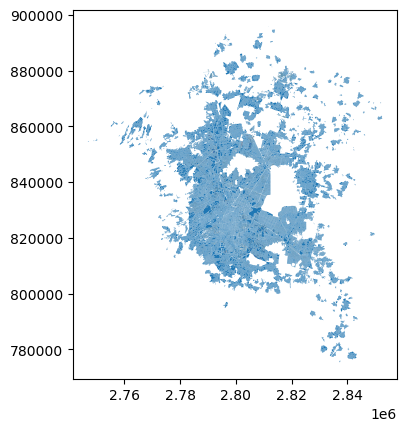

In [ ]:
manzanas.plot()            

### Datos del censo

Ya tenemos integradas las manzanas, ahoratenemos que integrar los datos del Censo. Para el Censo de 2020 INEGI publica un csv con los resultados por AGEB y manzana urbana combinados, entonces tenemos que, además de hacer la concatenación de las bases, seleccionar únicamente los resultados a nivel manzana.

Entonces, una vez más, suponiendo que tenemos los datos guardados en la carpeta `DOWNLOADS_PATH`:

In [ ]:
# Leemos el archivo
pth = os.path.abspath(os.path.join(DOWNLOADS_PATH, 'conjunto_de_datos_ageb_urbana_09_cpv2020.zip'))
censo_cdmx = pd.read_csv(pth, dtype={"ENTIDAD":str, "MUN": str, "LOC":str, "AGEB":str, "MZA": str})
# Nos quedamos sólo con las filas que tienen datos de manzanas (no localidad, agebs, etc)
censo_cdmx = censo_cdmx.loc[censo_cdmx['MZA'] != '000']
# Construimos la cvegeo de las manzanas
censo_cdmx['CVEGEO'] = censo_cdmx['ENTIDAD'] + censo_cdmx['MUN'] + censo_cdmx['LOC'] + censo_cdmx['AGEB'] + censo_cdmx['MZA']
censo_cdmx.head()

,ENTIDAD,NOM_ENT,MUN,NOM_MUN,LOC,NOM_LOC,AGEB,MZA,POBTOT,POBFEM,...,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC,CVEGEO
4,09,Ciudad de México,002,Azcapotzalco,0001,Azcapotzalco,0010,001,159,86,...,42,39,18,13,6,*,0,9,0,0900200010010001
5,09,Ciudad de México,002,Azcapotzalco,0001,Azcapotzalco,0010,002,145,80,...,38,32,14,12,5,0,0,9,0,0900200010010002
6,09,Ciudad de México,002,Azcapotzalco,0001,Azcapotzalco,0010,003,124,64,...,28,25,11,15,7,0,*,6,0,0900200010010003
7,09,Ciudad de México,002,Azcapotzalco,0001,Azcapotzalco,0010,004,158,83,...,38,34,14,4,7,0,0,7,0,0900200010010004
8,09,Ciudad de México,002,Azcapotzalco,0001,Azcapotzalco,0010,005,154,86,...,42,38,12,5,6,0,0,7,0,0900200010010005


Ahora necesitamos corregir los valores _nodata_ y usar los tipos de datos adecuados. Para eso vamos a necesitar el diccionario de datos del Censo, que también se puede descargar de su siio

In [ ]:
fname = 'diccionario_datos_ageb_urbana_09_cpv2020.csv'
absp = os.path.abspath(os.path.join(DOWNLOADS_PATH, fname))
dicionario = pd.read_csv(absp, skiprows=3)
diccionario = (dicionario
                .drop(range(0,8))
                .drop(columns='Núm.')
                .reset_index(drop=True)
                .rename({'Mnemónico':'Nombre del Campo'}, axis=1))
diccionario

,Indicador,Descripción,Nombre del Campo,Rangos,Longitud
0,Población total,Total de personas que residen habitualmente en...,POBTOT,0...999999999,9
1,Población femenina,Total de mujeres que residen habitualmente en ...,POBFEM,0...999999999,9
2,Población masculina,Total de hombres que residen habitualmente en ...,POBMAS,0...999999999,9
3,Población de 0 a 2 años,Personas de 0 a 2 años de edad.,P_0A2,0…999999999,9
4,Población femenina de 0 a 2 años,Mujeres de 0 a 2 años de edad.,P_0A2_F,"0.,.999999999",9
...,...,...,...,...,...
217,Viviendas particulares habitadas que disponen ...,Viviendas particulares habitadas que tienen co...,VPH_CVJ,0…999999999,9
218,Viviendas particulares habitadas sin radio ni ...,Viviendas particulares habitadas que no cuenta...,VPH_SINRTV,0…999999999,9
219,Viviendas particulares habitadas sin línea tel...,Viviendas particulares habitadas que no cuenta...,VPH_SINLTC,0…999999999,9
220,Viviendas particulares habitadas sin computado...,Viviendas particulares habitadas que no cuenta...,VPH_SINCINT,0…999999999,9


Ya con el diccionario podemos arreglar la base

In [ ]:
# Codificamos los Nan
censo_cdmx = (censo_cdmx
              .replace('999999999', np.nan)
              .replace('99999999', np.nan)
              .replace('*', np.nan)
              .replace('N/D', np.nan)) 

# Cambiamos los tipos de datos
campos_datos = diccionario['Nombre del Campo'].unique()
censo_cdmx[campos_datos] = censo_cdmx[campos_datos].astype('float')
censo_cdmx.dtypes

ENTIDAD         object
NOM_ENT         object
MUN             object
NOM_MUN         object
LOC             object
                ...   
VPH_SINRTV     float64
VPH_SINLTC     float64
VPH_SINCINT    float64
VPH_SINTIC     float64
CVEGEO          object
Length: 231, dtype: object

Hacemos lo mismo para Edomex e Hidalgo 

In [ ]:
# Leemos el archivo
pth = os.path.abspath(os.path.join(DOWNLOADS_PATH, 'conjunto_de_datos_ageb_urbana_13_cpv2020.zip'))
censo_hgo = pd.read_csv(pth, dtype={"ENTIDAD":str, "MUN": str, "LOC":str, "AGEB":str, "MZA": str})
# Nos quedamos sólo con las filas que tienen datos de manzanas (no localidad, agebs, etc)
censo_hgo = censo_hgo.loc[censo_hgo['MZA'] != '000']
# Construimos la cvegeo de las manzanas
censo_hgo['CVEGEO'] = censo_hgo['ENTIDAD'] + censo_hgo['MUN'] + censo_hgo['LOC'] + censo_hgo['AGEB'] + censo_hgo['MZA']
# Leemos el archivo
pth = os.path.abspath(os.path.join(DOWNLOADS_PATH, 'conjunto_de_datos_ageb_urbana_15_cpv2020.zip'))
censo_mex = pd.read_csv(pth, dtype={"ENTIDAD":str, "MUN": str, "LOC":str, "AGEB":str, "MZA": str})
# Nos quedamos sólo con las filas que tienen datos de manzanas (no localidad, agebs, etc)
censo_mex = censo_mex.loc[censo_mex['MZA'] != '000']
# Construimos la cvegeo de las manzanas
censo_mex['CVEGEO'] = censo_mex['ENTIDAD'] + censo_mex['MUN'] + censo_mex['LOC'] + censo_mex['AGEB'] + censo_mex['MZA']
# Codificamos los Nan
censo_hgo = (censo_hgo
              .replace('999999999', np.nan)
              .replace('99999999', np.nan)
              .replace('*', np.nan)
              .replace('N/D', np.nan)) 

censo_hgo[campos_datos] = censo_hgo[campos_datos].astype('float')
censo_mex = (censo_mex
              .replace('999999999', np.nan)
              .replace('99999999', np.nan)
              .replace('*', np.nan)
              .replace('N/D', np.nan)) 

censo_mex[campos_datos] = censo_mex[campos_datos].astype('float')

Concatenamos y unimos a las geometrías que calculamos arriba

In [ ]:
censo = pd.concat([censo_cdmx, censo_hgo, censo_mex])
manzanas = (manzanas
            .merge(censo, on='CVEGEO')
            .drop(columns=['ENTIDAD', 'NOM_ENT', 'MUN', 'NOM_MUN', 'LOC', 'NOM_LOC', 'AGEB', 'MZA']))
manzanas.head()

,CVEGEO,AMBITO,TIPOMZA,geometry,POBTOT,POBFEM,POBMAS,P_0A2,P_0A2_F,P_0A2_M,...,VPH_TELEF,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC
0,0901000010898031,Urbana,Típica,"POLYGON ((2790204.135 820779.247, 2790125.593 ...",93.0,56.0,37.0,4.0,NaN,3.0,...,20.0,19.0,15.0,16.0,6.0,3.0,0.0,0.0,7.0,0.0
1,0901000012269024,Urbana,Típica,"POLYGON ((2791387.916 821465.156, 2791376.215 ...",6.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0901000011472068,Urbana,Típica,"POLYGON ((2788494.355 822775.106, 2788478.422 ...",124.0,66.0,58.0,3.0,3.0,0.0,...,25.0,29.0,25.0,22.0,9.0,8.0,0.0,NaN,7.0,0.0
3,0901000011824024,Urbana,Típica,"POLYGON ((2790870.494 819456.298, 2790862.256 ...",340.0,177.0,163.0,12.0,8.0,4.0,...,54.0,90.0,69.0,56.0,29.0,14.0,NaN,NaN,25.0,NaN
4,0901000012377004,Urbana,Típica,"POLYGON ((2792111.138 821977.886, 2792115.437 ...",82.0,41.0,41.0,NaN,0.0,NaN,...,15.0,21.0,13.0,13.0,6.0,3.0,0.0,0.0,9.0,0.0


Aquí ya tenemos todas las manzanas unidas y con datos. Ya sólo hay que exportar.

In [ ]:
manzanas.merge(censo, on='CVEGEO')

,CVEGEO,AMBITO,TIPOMZA,geometry,ENTIDAD,NOM_ENT,MUN,NOM_MUN,LOC,NOM_LOC,...,VPH_TELEF,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC
0,0901000010898031,Urbana,Típica,"POLYGON ((2790204.135 820779.247, 2790125.593 ...",09,Ciudad de México,010,Álvaro Obregón,0001,Álvaro Obregón,...,20.0,19.0,15.0,16.0,6.0,3.0,0.0,0.0,7.0,0.0
1,0901000012269024,Urbana,Típica,"POLYGON ((2791387.916 821465.156, 2791376.215 ...",09,Ciudad de México,010,Álvaro Obregón,0001,Álvaro Obregón,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0901000011472068,Urbana,Típica,"POLYGON ((2788494.355 822775.106, 2788478.422 ...",09,Ciudad de México,010,Álvaro Obregón,0001,Álvaro Obregón,...,25.0,29.0,25.0,22.0,9.0,8.0,0.0,NaN,7.0,0.0
3,0901000011824024,Urbana,Típica,"POLYGON ((2790870.494 819456.298, 2790862.256 ...",09,Ciudad de México,010,Álvaro Obregón,0001,Álvaro Obregón,...,54.0,90.0,69.0,56.0,29.0,14.0,NaN,NaN,25.0,NaN
4,0901000012377004,Urbana,Típica,"POLYGON ((2792111.138 821977.886, 2792115.437 ...",09,Ciudad de México,010,Álvaro Obregón,0001,Álvaro Obregón,...,15.0,21.0,13.0,13.0,6.0,3.0,0.0,0.0,9.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178120,130690044075A027,Urbana,Típica,"POLYGON ((2816825.604 878727.078, 2816797.128 ...",13,Hidalgo,069,Tizayuca,0044,Haciendas de Tizayuca,...,0.0,21.0,12.0,7.0,NaN,3.0,NaN,NaN,8.0,NaN
178121,1306900051122013,Urbana,Típica,"POLYGON ((2816889.514 875827.863, 2816832.976 ...",13,Hidalgo,069,Tizayuca,0005,Emiliano Zapata,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
178122,1306900051122007,Urbana,Típica,"POLYGON ((2816847.444 875908.212, 2816843.426 ...",13,Hidalgo,069,Tizayuca,0005,Emiliano Zapata,...,NaN,7.0,4.0,4.0,3.0,3.0,0.0,0.0,NaN,0.0
178123,1306900190410091,Urbana,Típica,"POLYGON ((2818985.457 875021.200, 2818993.366 ...",13,Hidalgo,069,Tizayuca,0019,Tepojaco,...,0.0,4.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0


In [ ]:
manzanas.to_file("../../datos/descargas/manzanas_datos.gpkg", layer='manzanas')